In [2]:
import os

import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload

%autoreload 2

In [2]:
tf.executing_eagerly()

True

In [3]:
list_ds = tf.data.experimental.make_csv_dataset(
            os.path.join(os.getcwd(), '..', 'data', 'final_dataset_val_demo.csv'),
            batch_size=1,
            num_epochs=1,
            label_name='has_animal',
            prefetch_buffer_size=None,
            num_rows_for_inference=100,
            compression_type=None,
            ignore_errors=False
            )

Instructions for updating:
Use `tf.data.Dataset.interleave(map_func, cycle_length, block_length, num_parallel_calls=tf.data.experimental.AUTOTUNE)` instead. If sloppy execution is desired, use `tf.data.Options.experimental_determinstic`.


In [4]:
def show_batch(dataset):
    for batch, label in dataset.take(4):
        for key, value in batch.items():
            print("{:20s}: {}".format(key,value.numpy()))
        print(label.numpy())

In [5]:
show_batch(list_ds)

sequence            : [21]
image1              : [b'120516010928001a1601.JPG']
image2              : [b'120516010928001a1602.JPG']
image3              : [b'120516010928001a1603.JPG']
[1]
sequence            : [24]
image1              : [b'090516043918001a1601.JPG']
image2              : [b'090516043918001a1602.JPG']
image3              : [b'090516043918001a1603.JPG']
[0]


In [6]:
def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    
    return img

In [24]:
def parse_data(metadata, label):
    data_point = {}
    for img_name in ['image1', 'image2', 'image3']:
        img = tf.io.read_file(tf.strings.join([os.path.join(os.getcwd(), '..', 'data', 'images'), 
                                               os.sep, metadata[img_name]])[0])
        img = decode_img(img)
        data_point[img_name] = img
    return data_point, label

In [25]:
new_ds = list(list_ds.map(parse_data, num_parallel_calls=tf.data.experimental.AUTOTUNE))

In [26]:
new_ds[0]

({'image1': <tf.Tensor: id=377, shape=(2448, 3264, 3), dtype=float32, numpy=
  array([[[0.07058824, 0.07058824, 0.07058824],
          [0.06666667, 0.06666667, 0.06666667],
          [0.09019608, 0.09019608, 0.09019608],
          ...,
          [0.45098042, 0.45098042, 0.45098042],
          [0.40784317, 0.40784317, 0.40784317],
          [0.37254903, 0.37254903, 0.37254903]],
  
         [[0.07450981, 0.07450981, 0.07450981],
          [0.07843138, 0.07843138, 0.07843138],
          [0.10588236, 0.10588236, 0.10588236],
          ...,
          [0.43529415, 0.43529415, 0.43529415],
          [0.40784317, 0.40784317, 0.40784317],
          [0.38823533, 0.38823533, 0.38823533]],
  
         [[0.07058824, 0.07058824, 0.07058824],
          [0.07843138, 0.07843138, 0.07843138],
          [0.10196079, 0.10196079, 0.10196079],
          ...,
          [0.4156863 , 0.4156863 , 0.4156863 ],
          [0.40784317, 0.40784317, 0.40784317],
          [0.40784317, 0.40784317, 0.40784317]],
  
  

In [10]:
def show_batch(image_batch, label_batch, k=2):
    plt.figure(figsize=(10,10))
    for n in range(k):
        ax = plt.subplot(1, k, n + 1)
        plt.imshow(image_batch[n])
        plt.axis('off')
        plt.title(label_batch[n].numpy())

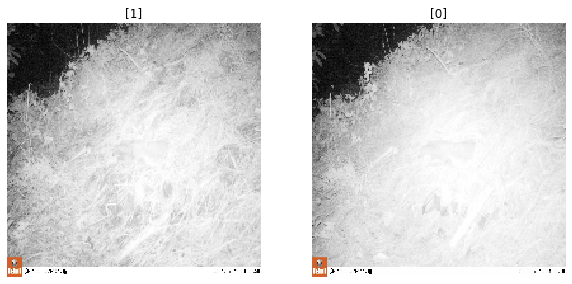

In [13]:
image_batch = [img for img, lab in new_ds]
label_batch = [lab for img, lab in new_ds]
show_batch(image_batch, label_batch)

## Alternative Pipeline Test

In [7]:
data_csv = pd.read_csv(os.path.join(os.getcwd(), '..', 'data', 'final_dataset_val_demo.csv'))

In [8]:
data_csv.head()

,sequence,image1,image2,image3,has_animal
0,21,120516010928001a1601.JPG,120516010928001a1602.JPG,120516010928001a1603.JPG,1
1,24,090516043918001a1601.JPG,090516043918001a1602.JPG,090516043918001a1603.JPG,0


In [9]:
file_paths = data_csv[['image1', 'image2', 'image3']]
labels = data_csv[['has_animal']]

In [10]:
dataset_files = tf.data.Dataset.from_tensor_slices((file_paths.to_dict('list'), labels.values.reshape(-1, )))

In [17]:
def parse_data(metadata, label):
#     data_point = {}
#     for img_name in ['image1', 'image2', 'image3']:
#         img = tf.io.read_file(tf.strings.join([os.path.join(os.getcwd(), '..', 'data', 'images'), 
#                                                os.sep, metadata[img_name]]))
#         img = decode_img(img)
#         data_point[img_name] = img
#     return data_point, label
    images = []
    
    # Read each image and add to list
    for img_name in ['image1', 'image2', 'image3']:
        img = tf.io.read_file(tf.strings.join([os.path.join(os.getcwd(), '..', 'data', 'images'), 
                                               os.sep, metadata[img_name]]))
        img = decode_img(img)
        images.append(img)

    return tf.convert_to_tensor(images), label

In [18]:
dataset_images = dataset_files.map(parse_data)

In [12]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(2):
        ax = plt.subplot(1, 2, n + 1)
        plt.imshow(image_batch[n])
        plt.axis('off')
        plt.title(label_batch[n].numpy())

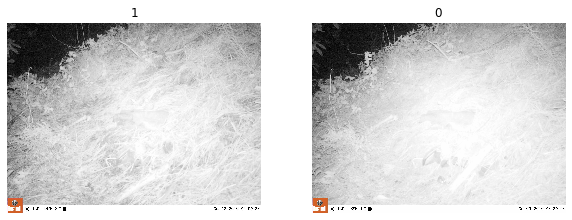

In [13]:
new_ds = iter(dataset_images)
image_batch = [img['image1'] for img, lab in new_ds]

new_ds = iter(dataset_images)
label_batch = [lab for img, lab in new_ds]
show_batch(image_batch, label_batch)

In [19]:
next(iter(dataset_images.batch(2)))

(<tf.Tensor: id=148, shape=(2, 3, 2448, 3264, 3), dtype=float32, numpy=
 array([[[[[0.15294118, 0.15294118, 0.15294118],
           [0.14117648, 0.14117648, 0.14117648],
           [0.12941177, 0.12941177, 0.12941177],
           ...,
           [0.34901962, 0.34901962, 0.34901962],
           [0.30588236, 0.30588236, 0.30588236],
           [0.27058825, 0.27058825, 0.27058825]],
 
          [[0.12156864, 0.12156864, 0.12156864],
           [0.1137255 , 0.1137255 , 0.1137255 ],
           [0.1137255 , 0.1137255 , 0.1137255 ],
           ...,
           [0.34509805, 0.34509805, 0.34509805],
           [0.3137255 , 0.3137255 , 0.3137255 ],
           [0.28627452, 0.28627452, 0.28627452]],
 
          [[0.09411766, 0.09411766, 0.09411766],
           [0.09411766, 0.09411766, 0.09411766],
           [0.10588236, 0.10588236, 0.10588236],
           ...,
           [0.34117648, 0.34117648, 0.34117648],
           [0.32941177, 0.32941177, 0.32941177],
           [0.31764707, 0.31764707, 0.317

In [122]:
def parse_data_flat(metadata, label):
    images, labels = [], []
    for img_name in ['image1', 'image2', 'image3']:
        img = tf.io.read_file(tf.strings.join([os.path.join(os.getcwd(), '..', 'data', 'images'), 
                                               os.sep, metadata[img_name]]))
        img = decode_img(img)
        images.append(img)
        labels.append(label)
    return tf.data.Dataset.from_tensor_slices((images, labels))

In [123]:
next(iter(dataset_files.flat_map(parse_data_flat, para).shuffle(buffer_size=10000, reshuffle_each_iteration=True).batch(6)))

(<tf.Tensor: id=1254, shape=(6, 2448, 3264, 3), dtype=float32, numpy=
 array([[[[0.05882353, 0.05882353, 0.05882353],
          [0.05882353, 0.05882353, 0.05882353],
          [0.0627451 , 0.0627451 , 0.0627451 ],
          ...,
          [0.45882356, 0.45882356, 0.45882356],
          [0.45098042, 0.45098042, 0.45098042],
          [0.45098042, 0.45098042, 0.45098042]],
 
         [[0.0509804 , 0.0509804 , 0.0509804 ],
          [0.05882353, 0.05882353, 0.05882353],
          [0.07058824, 0.07058824, 0.07058824],
          ...,
          [0.48627454, 0.48627454, 0.48627454],
          [0.47450984, 0.47450984, 0.47450984],
          [0.45882356, 0.45882356, 0.45882356]],
 
         [[0.06666667, 0.06666667, 0.06666667],
          [0.07450981, 0.07450981, 0.07450981],
          [0.09411766, 0.09411766, 0.09411766],
          ...,
          [0.49803925, 0.49803925, 0.49803925],
          [0.47450984, 0.47450984, 0.47450984],
          [0.45098042, 0.45098042, 0.45098042]],
 
         ...

In [ ]:
[[1,2,3],[4,5,6]]

In [104]:
dataset1 = tf.data.Dataset.from_tensor_slices(
    [[[1,2,3],[4,5,6]], [[1,2,3],[4,5,6]], [[1,2,3],[4,5,6]]])

dataset2 = tf.data.Dataset.from_tensors(
    [np.random.uniform(0, 1, (2, 3)), np.random.uniform(0, 1, (2, 3)), np.random.uniform(0, 1, (2, 3))])

print(next(iter(dataset1))) # shapes: (2, 3)
print(next(iter(dataset2))) # shapes: (2, 2, 3)

tf.Tensor(
[[1 2 3]
 [4 5 6]], shape=(2, 3), dtype=int32)
tf.Tensor(
[[[0.25052506 0.60764513 0.32726181]
  [0.19410323 0.78243375 0.17319819]]

 [[0.28262833 0.35615074 0.29835668]
  [0.26616135 0.22813303 0.06946989]]

 [[0.00943217 0.80698453 0.3767025 ]
  [0.37348604 0.8115013  0.1645897 ]]], shape=(3, 2, 3), dtype=float64)


In [105]:
for val in dataset1:
    print(val)

tf.Tensor(
[[1 2 3]
 [4 5 6]], shape=(2, 3), dtype=int32)
tf.Tensor(
[[1 2 3]
 [4 5 6]], shape=(2, 3), dtype=int32)
tf.Tensor(
[[1 2 3]
 [4 5 6]], shape=(2, 3), dtype=int32)


In [117]:
class Abc:
    RANDCONST = "32"
    
    def check(self, val=RANDCONST):
        return val == self.RANDCONST

In [119]:
Abc().check(22)

False

In [3]:
from data_pipeline import PipelineGenerator

In [55]:
demo_pipeline = PipelineGenerator(os.path.join(os.getcwd(), '..', 'data', 'final_dataset_val_demo.csv'),
                                  os.path.join(os.getcwd(), '..', 'data', 'images' + os.sep), 
                                  mode=PipelineGenerator.MODE_ALL)

#### For all mode

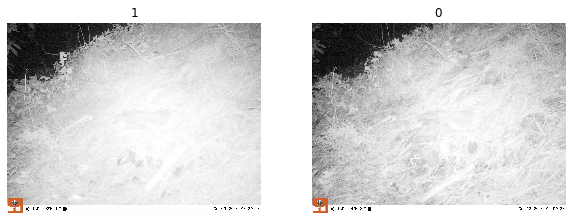

In [56]:
new_ds = iter(demo_pipeline.get_pipeline())
image_batch = [img['image1'] for img, lab in new_ds]

new_ds = iter(demo_pipeline.get_pipeline())
label_batch = [lab for img, lab in new_ds]
show_batch(image_batch, label_batch)

#### For flat mode

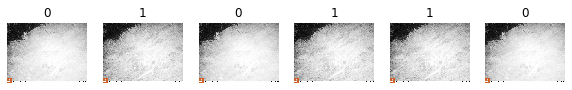

In [49]:
# new_ds = iter(demo_pipeline.get_pipeline())
image_batch, label_batch = zip(*demo_pipeline.get_pipeline().shuffle(buffer_size=1000, reshuffle_each_iteration=True))
show_batch(image_batch, label_batch, k=6)

#### For Single mode

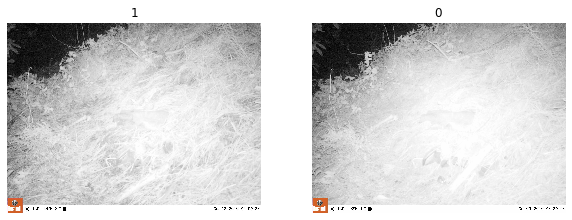

In [54]:
image_batch, label_batch = zip(*demo_pipeline.get_pipeline())
show_batch(image_batch, label_batch)

### Augmentation experiment

In [65]:
def flip(x, seed):
    """Flip augmentation

    Args:
        x: Image to flip

    Returns:
        Augmented image
    """
    print(seed)
    x = tf.image.random_flip_left_right(x, seed)
    print(x.shape)

    return x

In [66]:
class PipelineGenerator(object):
    """
    Creates a pipeline with the required configuration and image transformations
    (yet to come). Takes as input a CSV file which lists the images that needs
    to be loaded and transformed.
    
    NOTE: The dataset must have paths of the images in the sequences stored in 
          columns with names starting from 'image1', 'image2', and so on.
    
    Parameters:
    -----------
    dataset_file: Path to the CSV file containing the list of images and labels.
    
    images_dir: Path to the directory containing the images to be loaded.
    
    sequence_image_count: The number of images in each sequence. Default is 3.
    
    label_name: Name of the column in the CSV file corresponding to the label.
                Default is 'has_animal'.
                
    mode: The string representing the mode in which the data needs to be loaded. 
          For possible modes and definitions, check the 'Attributes' section. 
          Default is MODE_ALL.
          
    image_idx: Used when the selected mode is MODE_SINGLE. Specifies the index 
               of the image that needs to be picked. Must be > 0 and 
               <= sequence_image_count. Default is 1.

    resize: Specifies the size to which the images must be resized. Default is
            None. Must be provided as a list of integers specifying width and
            height. If None, no resizing is done.

    perform_shuffle: Specify if the dataset needs to be shuffled. Default: True.

    shuffle_buffer_size: Specifies the buffer size to use to shuffle the CSV
                         records. Check tensorflow.data.Dataset.shuffle() 
                         documentation for more details. Default is 10000.

    kwargs: Any additional keywords argument that needs to be passed to the 
            make_csv_dataset function of TensorFlow.
            
    Attributes:
    -----------
    MODE_ALL: Configuration to make the pipeline return all the images in a 
              dictionary with key as the original column name.
    
    MODE_FLAT_ALL: Configuration to make the pipeline returns all the images of 
                   the sequence one by one.
    
    MODE_SINGLE: Configuration to the pipeline return only the selected image 
                 from the sequence. Choice of image is specified by the 
                 parameter `image_idx`.
            
    """
    
    MODE_ALL = "mode_all"
    MODE_FLAT_ALL = "mode_flat_all"
    MODE_SINGLE = "mode_single"
    
    
    def __init__(self, dataset_file, images_dir, sequence_image_count=3, 
                 label_name='has_animal', mode=MODE_ALL, image_idx=1, 
                 resize=None, perform_shuffle=True, shuffle_buffer_size=10000, **kwargs):
        self._modes = [self.MODE_ALL, self.MODE_FLAT_ALL, self.MODE_SINGLE]
        self._dataset_file = dataset_file
        self._images_dir = images_dir
        self._sequence_image_count = sequence_image_count
        self._label_name = label_name
        self._mode = mode
        self._image_idx = image_idx
        self._resize = resize
        self._perform_shuffle = perform_shuffle
        self._shuffle_buffer_size = shuffle_buffer_size
        self._kwargs = kwargs
        self._AUTOTUNE = tf.data.experimental.AUTOTUNE
        
        if self._mode not in self._modes:
            raise ValueError("Invalid mode. Please select one from {}."\
                             .format(self._modes))
        
        if (self._mode == self.MODE_SINGLE and 
            (self._image_idx <= 0 or 
             self._image_idx > self._sequence_image_count)):
            raise IndexError("Image index is out of bounds.")
        
        if self._mode == self.MODE_ALL:
            self._parse_data = self._parse_data_all
        elif self._mode == self.MODE_FLAT_ALL:
            self._parse_data = self._parse_data_flat
        else:
            self._parse_data = self._parse_data_single


    def _decode_img(self, img):
        # Convert the compressed string to a 3D uint8 tensor
        img = tf.image.decode_jpeg(img, channels=3)

        # Use `convert_image_dtype` to convert to floats in the [0,1] range.
        img = tf.image.convert_image_dtype(img, tf.float32)

        # Resize the image to the desired size if needed.
        if self._resize:
            img = tf.image.resize(img, self._resize, name="resize-input")

        return img
    
    
    def _parse_data_all(self, metadata, label):
        data_point = {}
        
        # Read each image and add to dictionary
        for img_num in range(1, self._sequence_image_count + 1):
            img_name = "image" + str(img_num)
            img = tf.io.read_file(tf.strings.join([
                self._images_dir, metadata[img_name]]))
            img = self._decode_img(img)
            data_point[img_name] = img

        return data_point, label
    
    
    def _parse_data_single(self, metadata, label):
        img = tf.io.read_file(tf.strings.join([
                self._images_dir, metadata["image" + str(self._image_idx)]]))
        img = self._decode_img(img)
        
        return img, label
    
    
    def _parse_data_flat(self, metadata, label):
        images, labels = [], []
        # seed = tf.random.uniform([1], maxval=1000, dtype=tf.int32).numpy()[0]
        seed = np.random.randint(1000, size=1)[0]
        
        # Read each image and add to list
        for img_num in range(1, self._sequence_image_count + 1):
            img = tf.io.read_file(tf.strings.join([
                self._images_dir, metadata["image" + str(img_num)]]))
            img = self._decode_img(img)
            img = flip(img, seed)
            images.append(img)
            labels.append(label)
        
        return tf.data.Dataset.from_tensor_slices((images, labels))
    

    def get_pipeline(self):
        """
        Returns a pipeline that was constructed using the parameters specified.
        
        Returns:
        --------
        dataset_images: A tensorflow.data.Dataset pipeline object.
        
        """
        # Create a dataset with records from the CSV file.
        data_csv = pd.read_csv(self._dataset_file)
        image_col_names = ["image" + str(img_num) \
                           for img_num in range(1, self._sequence_image_count + 1)]
        file_paths = data_csv[image_col_names]
        labels = data_csv[[self._label_name]]
        dataset_files = tf.data.Dataset.from_tensor_slices((file_paths.to_dict('list'), labels.values.reshape(-1, )))

        if self._perform_shuffle:
            dataset_files = dataset_files.shuffle(buffer_size=self._shuffle_buffer_size, reshuffle_each_iteration=True)
        
        # Parse the data and load the images.
        if self._mode == self.MODE_FLAT_ALL:
            dataset_images = \
                dataset_files.flat_map(self._parse_data)
        else:
            dataset_images = \
                dataset_files.map(self._parse_data, 
                                  num_parallel_calls=self._AUTOTUNE)
        
        return dataset_images


871
(None, None, 3)
871
(None, None, 3)
871
(None, None, 3)


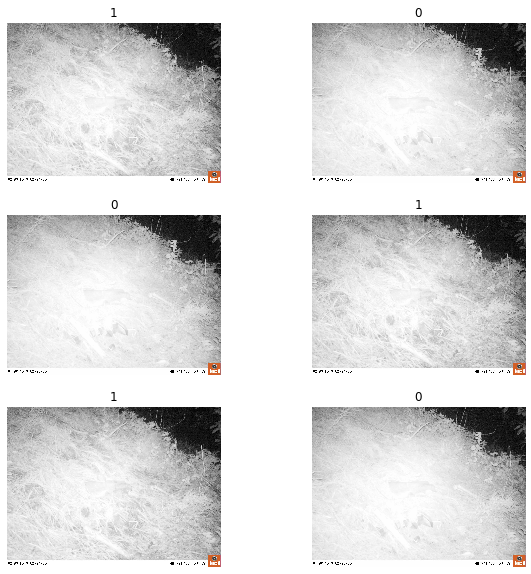

In [67]:
def show_batch(image_batch, label_batch, k=2):
    plt.figure(figsize=(10, 10))
    for n in range(k):
        ax = plt.subplot(3, k/3, n + 1)
        plt.imshow(image_batch[n])
        plt.axis('off')
        plt.title(label_batch[n].numpy())

demo_pipeline = PipelineGenerator(os.path.join(os.getcwd(), '..', 'data', 'final_dataset_val_demo.csv'),
                                  os.path.join(os.getcwd(), '..', 'data', 'images' + os.sep), 
                                  mode=PipelineGenerator.MODE_FLAT_ALL)

image_batch, label_batch = zip(*demo_pipeline.get_pipeline().shuffle(buffer_size=1000, reshuffle_each_iteration=True))
show_batch(image_batch, label_batch, k=6)

In [52]:
tf.random.uniform([1], maxval=1000, dtype=tf.int32)#.numpy()[0]

<tf.Tensor: id=1808, shape=(1,), dtype=int32, numpy=array([155], dtype=int32)>

In [64]:
np.random.randint(1000)

365

## Data Augmentation

In [3]:
from data_pipeline import PipelineGenerator

In [26]:
# def show_batch(image_batch, label_batch, k=2):
#     print("Here")
#     plt.figure(figsize=(10, 10))
#     for n in range(k):
#         ax = plt.subplot(3, k/3, n + 1)
#         plt.imshow(image_batch[n])
#         plt.axis('off')
#         plt.title(label_batch[n].numpy())

demo_pipeline = PipelineGenerator(os.path.join(os.getcwd(), '..', 'data', 'final_dataset_val_demo.csv'),
                                  os.path.join(os.getcwd(), '..', 'data', 'images' + os.sep), 
                                  mode=PipelineGenerator.MODE_FLAT_ALL, image_size=(2448, 3264))

pipeline = demo_pipeline.get_pipeline().batch(2).prefetch(1)

# for idx, (img, label) in enumerate(pipeline):
#     print(idx, label)
#     if idx > 8:
#         break

idx = 0
while idx < 9:
    _ = 

# image_batch, label_batch = zip(*demo_pipeline.get_pipeline().shuffle(buffer_size=1000, reshuffle_each_iteration=True))
# show_batch(image_batch, label_batch, k=10)

Note: The dataset is being prepared for training mode. It has been shuffled, and repeated indefinitely.
0 tf.Tensor([1 1], shape=(2,), dtype=int64)
1 tf.Tensor([1 0], shape=(2,), dtype=int64)
2 tf.Tensor([0 0], shape=(2,), dtype=int64)
0 tf.Tensor([1 1], shape=(2,), dtype=int64)
1 tf.Tensor([0 0], shape=(2,), dtype=int64)
2 tf.Tensor([1 0], shape=(2,), dtype=int64)
